# Predicting NASDAQ indexes during the COVID-19 pandemic

## Data preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
DATA_DIR = './my_data/'
df_healthcare = pd.read_csv(DATA_DIR + 'IXHC.csv')
df_biotech = pd.read_csv(DATA_DIR + 'NBI.csv')
df_healthcare.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
257,2020-11-02,1023.380005,1100.969971,1003.500000,1087.619995,1087.619995,5046800
258,2020-11-09,1099.530029,1106.780029,1065.349976,1104.359985,1104.359985,6324500
259,2020-11-16,1111.469971,1111.489990,1078.869995,1091.459961,1091.459961,5446500
260,2020-11-23,1098.770020,1123.569946,1088.209961,1123.569946,1123.569946,3373000
261,2020-11-30,1132.060059,1135.439941,1116.579956,1135.010010,1135.010010,3571800


Our datasets include stock indexes from 2015/12/01 to 2020/12/01.

The names of columns are quite staightforward. Here we take **NASDAQ HealthCare** as an example:
+ Date: the first day of every week.
+ Open: the opening price in each week.
+ High: the highest price in each week.
+ Low: the lowest price in each week.
+ Close: the closing price in each week. To be more specific, closing prices on every Friday.

It's noted that **Date** is the first day of the weekly summary rather than the last day and that is the first issue. Besides, as we can observe, 2020-11-30 is the first day of the week so the last row of **NASDAQ HealthCare** dataframe is just the summary of prices for two days (2020-11-30 and 2020/12/01). It's safe to drop it.

In [3]:
df_healthcare['Date'] = pd.to_datetime(df_healthcare['Date'])
df_healthcare['Date'] = df_healthcare['Date'] + pd.Timedelta('6d')
df_healthcare.set_index('Date', inplace=True)
df_healthcare = df_healthcare[0:-1]

Now the **NASDAQ HealthCare** dateset is exactly what we want:

In [4]:
df_healthcare.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,1059.619995,1067.189941,1003.510010,1013.820007,1013.820007,4118400
2020-11-08,1023.380005,1100.969971,1003.500000,1087.619995,1087.619995,5046800
2020-11-15,1099.530029,1106.780029,1065.349976,1104.359985,1104.359985,6324500
2020-11-22,1111.469971,1111.489990,1078.869995,1091.459961,1091.459961,5446500
2020-11-29,1098.770020,1123.569946,1088.209961,1123.569946,1123.569946,3373000


We do the same process again for **NASDAQ Biotechnology** dataset:

In [5]:
df_biotech['Date'] = pd.to_datetime(df_biotech['Date'])
df_biotech['Date'] = df_biotech['Date'] + pd.Timedelta('6d')
df_biotech.set_index('Date', inplace=True)
df_biotech = df_biotech[0:-1]

In [6]:
df_biotech.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,4252.459961,4286.129883,4054.510010,4097.970215,4097.970215,1099300
2020-11-08,4125.450195,4469.339844,4033.139893,4355.970215,4355.970215,1197000
2020-11-15,4374.060059,4446.140137,4277.850098,4436.250000,4436.250000,1014200
2020-11-22,4466.890137,4466.890137,4318.939941,4364.149902,4364.149902,1243900
2020-11-29,4395.709961,4505.310059,4342.129883,4505.310059,4505.310059,595300


Here, We process Google Trends data (also from 2015/12/01 to 2020/12/01) about topic "Vaccine". The tail of the result dataframe matches the previous NASDAQ data.

In [7]:
df_trends = pd.read_csv(DATA_DIR + 'trends_data.csv')
df_trends.drop(labels=['Week'], axis=0, inplace=True)
df_trends.index = pd.to_datetime(df_trends.index)
df_trends.index.set_names('Date', inplace=True)
df_trends.rename(columns={'Category: All categories': 'Vaccine'}, inplace=True)
df_trends['Vaccine'] = df_trends['Vaccine'].apply(lambda x: int(x))

In [8]:
df_trends.tail()

,Vaccine
Date,
2020-11-01,27
2020-11-08,85
2020-11-15,84
2020-11-22,70
2020-11-29,100


After the individual processing, all three datesets share the same time index and can be merged perfectly. We first experiment with the closing prices of both stocks.

In [9]:
data = pd.DataFrame({'healthcare': df_healthcare['Close'],
                     'biotech': df_biotech['Close'],
                     'vaccine': df_trends['Vaccine']})

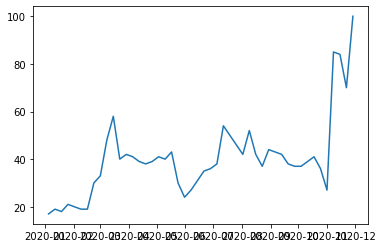

In [43]:
plt.plot(data[pd.Timestamp('2020-01-01'):]['vaccine'])

In [10]:
data.head(5)

,healthcare,biotech,vaccine
Date,,,
2015-12-06,743.700012,3470.639893,12
2015-12-13,718.440002,3347.600098,12
2015-12-20,735.000000,3449.010010,9
2015-12-27,757.659973,3555.060059,9
2016-01-03,752.390015,3540.439941,12


Let's take a look at the trends for both.

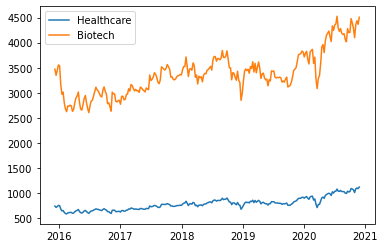

In [11]:
plt.plot(data['healthcare'], label='Healthcare')
plt.plot(data['biotech'], label='Biotech')
plt.legend()

It seems that **NASDAQ Healthcare** is much richer than the other one while facing wilder swings. 

To get a better grasp of how the both stocks fluctuate, let's compare another plot that uses standardized data.

In [12]:
def standardization(data):
    return (data-data.min())/(data.max()-data.min())

data['healthcare_std'] = standardization(data['healthcare'])
data['biotech_std'] = standardization(data['biotech'])

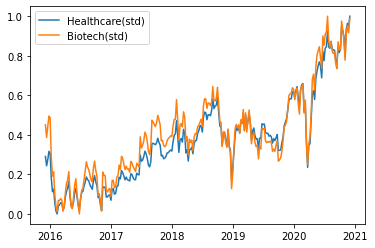

In [13]:
plt.plot(data['healthcare_std'], label='Healthcare(std)')
plt.plot(data['biotech_std'], label='Biotech(std)')
plt.legend()

Now the both trends over the past 5 years become more identical, and they seem to be in the same boat, rising and falling together.

In [14]:
import scipy.stats as stats
stats.pearsonr(data['healthcare'], data['biotech'])

(0.980973808774403, 2.1135374559961756e-186)

## Build the models

The baseline model can be concluded by the formula:

$$y_{t}^{health} \sim y_{t-1}^{health} + y_{t-4}^{health} + e$$

$y_t$: Closing price of NASDAQ Healthcare at time $t$.

$y_{t-4}$: Closing price of NASDAQ Healthcare at time $t-4$.

We now extract the features accordingly. Because there are no features available for the first 4 rows, so they need to be dropped.

In [15]:
data['healthcare.l1'] = data['healthcare'].shift(1)
data['biotech.l1'] = data['biotech'].shift(1)
data['healthcare.l4'] = data['healthcare'].shift(4)
data['biotech.l4'] = data['biotech'].shift(4)
data['vaccine.l1'] = data['vaccine'].shift(1)
data['vaccine.l4'] = data['vaccine'].shift(4)
data.dropna(inplace=True)
data.head()

,healthcare,biotech,vaccine,healthcare_std,biotech_std,healthcare.l1,biotech.l1,healthcare.l4,biotech.l4,vaccine.l1,vaccine.l4
Date,,,,,,,,,,,
2016-01-03,752.390015,3540.439941,12,0.306789,0.487119,757.659973,3555.060059,743.700012,3470.639893,9.0,12.0
2016-01-10,685.900024,3160.219971,12,0.182613,0.289124,752.390015,3540.439941,718.440002,3347.600098,12.0,12.0
2016-01-17,648.380005,2972.570068,12,0.112541,0.191408,685.900024,3160.219971,735.000000,3449.010010,12.0,9.0
2016-01-24,655.340027,3013.870117,13,0.125539,0.212914,648.380005,2972.570068,757.659973,3555.060059,12.0,9.0
2016-01-31,618.659973,2796.469971,13,0.057036,0.099706,655.340027,3013.870117,752.390015,3540.439941,13.0,12.0


In [16]:
base_X = data[['healthcare.l1', 'healthcare.l4']]
base_X = sm.add_constant(base_X)
base_y = data['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2688.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          1.27e-171
Time:                        06:53:24   Log-Likelihood:                -1202.1
No. Observations:                 257   AIC:                             2410.
Df Residuals:                     254   BIC:                             2421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0211     11.180      0.449

Old people always say that the stock market is unpredictable. We have learned the same lesson from the paper that we were asked to replicate. 

> As Nelson and Plosser (1982) and many subsequent authors have pointed out, it is very common for macroeconomic data to be represented as a random walk. For a random walk, the best univariate forecast for $y_t$ is simply $yt_1$. 

Let's see if we can gain slightly better $R^2$ by replacing $y_{t-4}^{health}$ with another feature.

In [17]:
base_X = data[['healthcare.l1', 'biotech.l1']]
base_X = sm.add_constant(base_X)
base_y = data['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2738.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          1.34e-172
Time:                        06:53:24   Log-Likelihood:                -1199.8
No. Observations:                 257   AIC:                             2406.
Df Residuals:                     254   BIC:                             2416.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            38.2208     16.556      2.309

In [18]:
base_X = data[['healthcare.l1', 'vaccine.l1']]
base_X = sm.add_constant(base_X)
base_y = data['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2687.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          1.32e-171
Time:                        06:53:24   Log-Likelihood:                -1202.2
No. Observations:                 257   AIC:                             2410.
Df Residuals:                     254   BIC:                             2421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            15.2324     12.865      1.184

In [19]:
base_X = data[['healthcare.l1', 'biotech.l1', 'vaccine.l1']]
base_X = sm.add_constant(base_X)
base_y = data['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1822.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          6.32e-171
Time:                        06:53:24   Log-Likelihood:                -1199.6
No. Observations:                 257   AIC:                             2407.
Df Residuals:                     253   BIC:                             2421.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            41.6369     17.343      2.401

We have tried NASDAQ Biotechnology index, Google Trends on "Vaccine", and both of the new features. A surprising find is that, in the long run (in our case, 5 years), only NASDAQ Biotechnology index brings tiny improvement to the models with convincing p-value. However, Google Trends is likely to make no contribution to the models.

## A different direction: COVID-19 

It's time to scale our scope to this extraordinary year. One of the most significant event has changed the lives of countless millions of people. COVID-19 is still rife and must have caused unfathomable imfluence over the global economics. 

There is no doubt that the most iconic data about COVID-19 is the number of new cases for each day in each area. In order to explore the changes of stock market as far as possible, we utilize the COVID-19 data that comes from the European Union and focus on the new cases in USA.

In [20]:
df_cases = pd.read_csv(DATA_DIR + 'covid.csv')
df_us_covid = df_cases[df_cases['location'] == 'United States'] 
df_us_covid.set_index('date', inplace=True)
df_us_covid.fillna(0)
df_us_covid.index = pd.to_datetime(df_us_covid.index)
df_cases_weekly = df_us_covid.groupby(pd.Grouper(freq='1w')).sum()

After preprocessing, we get the relevant data for each week:

In [21]:
df_cases_weekly.tail()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,
2020-11-08,67554757.0,800873.0,698590.571,1650021.0,7020.0,6591.856,204091.288,2419.537,2110.529,4984.917,...,379578.122,8.4,1057.623,75.53,133.7,172.2,0.0,19.39,552.02,6.468
2020-11-15,74106406.0,1043959.0,935949.857,1701506.0,7737.0,7355.001,223884.633,3153.929,2827.620,5140.461,...,379578.122,8.4,1057.623,75.53,133.7,172.2,0.0,19.39,552.02,6.468
2020-11-22,82132943.0,1193362.0,1146648.144,1766317.0,10577.0,9258.714,248133.795,3605.295,3464.168,5336.262,...,379578.122,8.4,1057.623,75.53,133.7,172.2,0.0,19.39,552.02,6.468
2020-11-29,90382596.0,1136507.0,1178521.858,1841167.0,10004.0,10692.857,273057.018,3433.527,3560.460,5562.393,...,379578.122,8.4,1057.623,75.53,133.7,172.2,0.0,19.39,552.02,6.468
2020-12-06,84273368.0,1197967.0,1039163.143,1648576.0,14313.0,10611.715,254600.284,3619.207,3139.441,4980.552,...,325352.676,7.2,906.534,64.74,114.6,147.6,0.0,16.62,473.16,5.544


Now integrate and filter the data in 2020.

In [22]:
data['new_cases'] = df_cases_weekly['new_cases']
data['new_deaths'] = df_cases_weekly['new_deaths']
data_2020 = data.dropna()

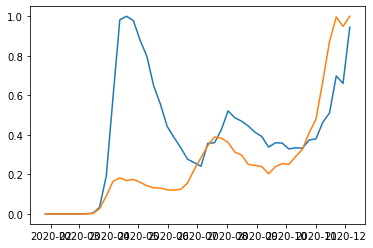

In [23]:
plt.plot(standardization(df_cases_weekly['new_deaths']))
plt.plot(standardization(df_cases_weekly['new_cases']))

Another round of traing using data in 2020.

In [24]:
base_X = data_2020[['healthcare.l1']]
base_X = sm.add_constant(base_X)
base_y = data_2020['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     210.0
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           3.76e-18
Time:                        06:53:24   Log-Likelihood:                -229.49
No. Observations:                  45   AIC:                             463.0
Df Residuals:                      43   BIC:                             466.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            68.8500     63.037      1.092

In [25]:
base_X = data_2020[['healthcare.l1', 'vaccine.l1']]
base_X = sm.add_constant(base_X)
base_y = data_2020['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     102.6
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           6.87e-17
Time:                        06:53:24   Log-Likelihood:                -229.48
No. Observations:                  45   AIC:                             465.0
Df Residuals:                      42   BIC:                             470.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            68.6639     63.816      1.076

In [26]:
base_X = data_2020[['healthcare.l1', 'new_cases']]
base_X = sm.add_constant(base_X)
base_y = data_2020['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     117.6
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           6.14e-18
Time:                        06:53:24   Log-Likelihood:                -226.89
No. Observations:                  45   AIC:                             459.8
Df Residuals:                      42   BIC:                             465.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           163.1948     73.222      2.229

In [27]:
base_X = data_2020[['healthcare.l1', 'new_deaths']]
base_X = sm.add_constant(base_X)
base_y = data_2020['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     122.4
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           3.00e-18
Time:                        06:53:24   Log-Likelihood:                -226.13
No. Observations:                  45   AIC:                             458.3
Df Residuals:                      42   BIC:                             463.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            57.4146     59.360      0.967

In [28]:
data_2020.index

DatetimeIndex(['2020-01-26', '2020-02-02', '2020-02-09', '2020-02-16',
               '2020-02-23', '2020-03-01', '2020-03-08', '2020-03-15',
               '2020-03-22', '2020-03-29', '2020-04-05', '2020-04-12',
               '2020-04-19', '2020-04-26', '2020-05-03', '2020-05-10',
               '2020-05-17', '2020-05-24', '2020-05-31', '2020-06-07',
               '2020-06-14', '2020-06-21', '2020-06-28', '2020-07-05',
               '2020-07-12', '2020-07-19', '2020-07-26', '2020-08-02',
               '2020-08-09', '2020-08-16', '2020-08-23', '2020-08-30',
               '2020-09-06', '2020-09-13', '2020-09-20', '2020-09-27',
               '2020-10-04', '2020-10-11', '2020-10-18', '2020-10-25',
               '2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
               '2020-11-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [29]:
start_date = pd.Timestamp('2020-05-31')
start_index = data_2020.index.tolist().index(start_date)

base = [-1.0] * start_index
trends = [-1.0] * start_index
cases = [-1.0] * start_index
deaths = [-1.0] * start_index

### Traing for out-sample forecasting. Here we use sklearn lib. 
out_base_model = LinearRegression()
out_trends_model = LinearRegression()
out_cases_model = LinearRegression()
out_deaths_model = LinearRegression()

label = 'healthcare'
base_features = ['healthcare.l1']
trends_features = ['healthcare.l1', 'vaccine']
cases_features = ['healthcare.l1', 'new_cases']
deaths_features = ['healthcare.l1', 'new_deaths']

In [30]:
# As the rolling window become broader, more data can be used for trainig. 
for i in range(start_index, len(data_2020)):
    # Base model traing and predicting.
    out_base_model.fit(data_2020[:i][base_features], data_2020[:i][label])
    base_pred = out_base_model.predict([data_2020.iloc[i][base_features]])
    base.append(base_pred[0])

    # Trends model training and predicting.
    out_trends_model.fit(data_2020[:i][trends_features], data_2020[:i][label])
    trends_pred = out_trends_model.predict([data_2020.iloc[i][trends_features]])
    trends.append(trends_pred[0])
    
    out_cases_model.fit(data_2020[:i][cases_features], data_2020[:i][label])
    cases_pred = out_cases_model.predict([data_2020.iloc[i][cases_features]])
    cases.append(cases_pred[0])
    
    out_deaths_model.fit(data_2020[:i][deaths_features], data_2020[:i][label])
    deaths_pred = out_deaths_model.predict([data_2020.iloc[i][deaths_features]])
    deaths.append(deaths_pred[0])

In [31]:
data_2020['base'] = base
data_2020['trends'] = trends
data_2020['cases'] = cases
data_2020['deaths'] = deaths

<ipython-input-31-165be2807c78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['base'] = base
<ipython-input-31-165be2807c78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['trends'] = trends
<ipython-input-31-165be2807c78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

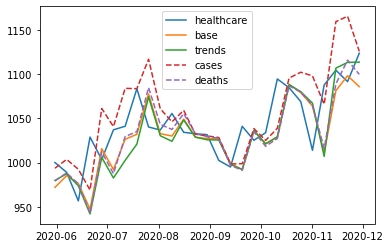

In [32]:
plt.plot(data_2020[start_date:]['healthcare'], label='healthcare')
plt.plot(data_2020[start_date:]['base'], label='base')
plt.plot(data_2020[start_date:]['trends'], label='trends')
plt.plot(data_2020[start_date:]['cases'], '--', label='cases')
plt.plot(data_2020[start_date:]['deaths'], '--', label='deaths')
plt.legend()

In [33]:
result = data_2020[start_date:]
base_mae = sum(abs(result['base'] - result[label]))/len(result[label])
trends_mae = sum(abs(result['trends'] - result[label]))/len(result[label])
cases_mae = sum(abs(result['cases'] - result[label]))/len(result[label])
deaths_mae = sum(abs(result['deaths'] - result[label]))/len(result[label])
print(base_mae)
print(trends_mae)
print(cases_mae)
print(deaths_mae)

26.698202347410877
26.875632352230404
29.177626715240848
26.11392238731168


In [34]:
df_gov = pd.read_csv(DATA_DIR + 'OxCGRT_latest.csv')
df_gov_us = df_gov[df_gov['CountryName'] == 'United States']

D:\miniconda\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [35]:
df_gov_us['RegionName'].unique()

array([nan, 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'Washington DC', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana',
       'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland',
       'Maine', 'Michigan', 'Minnesota', 'Missouri', 'Mississippi',
       'Montana', 'North Carolina', 'North Dakota', 'Nebraska',
       'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 'New York',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Virginia', 'Virgin Islands', 'Vermont', 'Washington', 'Wisconsin',
       'West Virginia', 'Wyoming'], dtype=object)

In [36]:
data_gov = df_gov_us[df_gov_us['RegionName'] == 'New York']
data_gov.set_index('Date', inplace=True)
data_gov.index = pd.to_datetime(data_gov.index, format="%Y%m%d")

In [37]:
data_gov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 2020-01-01 to 2020-12-09
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CountryName                            344 non-null    object 
 1   CountryCode                            344 non-null    object 
 2   RegionName                             344 non-null    object 
 3   RegionCode                             344 non-null    object 
 4   Jurisdiction                           344 non-null    object 
 5   C1_School closing                      343 non-null    float64
 6   C1_Flag                                272 non-null    float64
 7   C2_Workplace closing                   343 non-null    float64
 8   C2_Flag                                275 non-null    float64
 9   C3_Cancel public events                343 non-null    float64
 10  C3_Flag                                272 non-null    

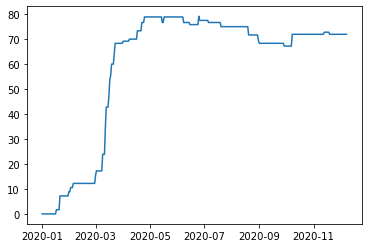

In [38]:
new_feature = 'GovernmentResponseIndexForDisplay'
plt.plot(data_gov[new_feature])

In [39]:
data_gov_weekly = data_gov.groupby(pd.Grouper(freq='1w')).max()

In [40]:
data_2020['gov'] = data_gov_weekly[new_feature]
base_X = data_2020[['healthcare.l1', 'new_cases', 'gov']]
base_X = sm.add_constant(base_X)
base_y = data_2020['healthcare']
base_model = sm.OLS(base_y, base_X).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:             healthcare   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     79.72
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           3.75e-17
Time:                        06:53:25   Log-Likelihood:                -226.12
No. Observations:                  45   AIC:                             460.2
Df Residuals:                      41   BIC:                             467.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           150.1545     73.650      2.039

<ipython-input-40-e46240caad00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['gov'] = data_gov_weekly[new_feature]


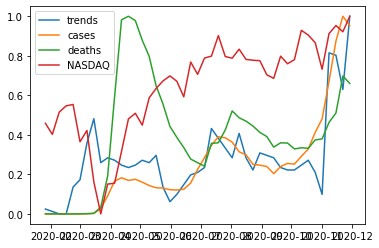

In [48]:
plt.plot(standardization(data_2020['vaccine']), label='trends')
plt.plot(standardization(data_2020['new_cases']), label='cases')
plt.plot(standardization(data_2020['new_deaths']), label='deaths')
plt.plot(standardization(data_2020['healthcare']), label='NASDAQ')
plt.legend()

In [49]:
stats.pearsonr(data_2020['vaccine'], data_2020['new_cases'])

(0.7911772280379495, 9.920076666751437e-11)

In [50]:
stats.pearsonr(data_2020['vaccine'], data_2020['new_deaths'])

(0.31105631469875267, 0.037542285092725995)

In [51]:
stats.pearsonr(data_2020['vaccine'], data_2020['healthcare'])

(0.3688584860695151, 0.012653928732466764)

In [52]:
stats.pearsonr(data_2020['new_deaths'], data_2020['healthcare'])

(0.21250621159579458, 0.16106870561899964)